In [101]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime
from pynvml import *

os.environ['http_proxy'] = "http://squid-a10.prod.ice.int.threatmetrix.com:3128"
os.environ['https_proxy'] = "http://squid-a10.prod.ice.int.threatmetrix.com:3128" 

from pathlib import Path
home = str(Path.home())
print(home)
print(sys.executable)
from utils.data_config import input_config
from utils.fraud_data import FraudData

# importing pytorch libraries
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# huggingface related
from datasets import Dataset
from transformers import MobileBertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import BertConfig, BertForMaskedLM
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments, logging
from transformers import pipeline,TextClassificationPipeline
from transformers import BertTokenizer, BertModel

# GBM related
from xgboost import XGBClassifier

# importing data science libraries
import pandas as pd
import numpy as np
import pickle as pkl

# model interpretation
import shap
shap.initjs()
from bertviz import head_view, model_view
from bertviz.neuron_view import show
from transformers_interpret import SequenceClassificationExplainer
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display
%load_ext autoreload
%autoreload 2

/home/zhanyi02
/home/zhanyi02/mltest/bin/python
1.10.1+cu102


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.0 Support Func

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device

# convert a df to tensor to be used in pytorch
def numpy_to_tensor(ay, tp):
    device = get_device()
    return torch.from_numpy(ay).type(tp).to(device)

### 1.1 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [3]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20221205-03:17:36] The CUDNN backend version: 7605


### 1.2 CPU/GPU Device

In [4]:
torch.backends.cudnn.benchmark = True 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
torch.cuda.device_count()

1

### 1.3 Python and PyTorch Verification

In [8]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20221205-03:17:38] The Python version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [9]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20221205-03:17:39] The PyTorch version: 1.10.1+cu102


### 1.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [10]:
# init deterministic seed
seed_value = 1234
random.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

## 2. Fraud Data

Load feature data generated by Flagship model, Step 2

> borrow some codes from flagship model

### 2.1 Load the Parsed Data

In [11]:
config = input_config("US_banking_login_test") #### like "US_ecommerce_login_test"
output_folder = config["output_folder"]

date, event_type, primary_industry = config["date_range"][0], config["event_types"][0], config["primary_industry"][0]
df = pd.read_csv(output_folder + f'/Data/fe_{primary_industry}_{event_type}_{date[0]}_{date[1]}.csv')
df.rename({'tmxrc_Possible VPN or Tunnel': 'tmxrc_Possible_VPN_or_Tunnel'}, axis=1, inplace=True)

### 2.2 Check Data

In [12]:
org_rcs=[x for x in df.columns if x.startswith(('tmxrc','sumrc'))]
print('data shape: ', df.shape)
print('total rcs: ', len(org_rcs))
print('frd by orgs: ', df[['org_id','frd','policy']].groupby(['org_id','frd']).agg(['count']))

data shape:  (934775, 186)
total rcs:  178
frd by orgs:                policy
               count
org_id   frd        
15saug00 0     32242
         1     16143
16xsqggn 0     96695
         1     17112
4rvrfbxt 0     93240
         1     10398
5h8i3ud8 0    123451
         1      8861
5mem3i7z 0     25109
         1      8749
60tfck6a 0     77370
         1     18260
89oebq5k 0     69120
         1     11695
8s1rqgxh 0     90235
         1     12802
i8n5h0pw 0    116454
         1     16016
qn4omaj3 0     76892
         1     13394


#### Input features

> Read feature list

In [13]:
modified_coef = pd.read_csv(output_folder + '/initial_output/modified_coef_final4th.csv',index_col='Unnamed: 0')

In [14]:
modified_coef.shape

(45, 1)

In [15]:
modified_rcs = list(modified_coef.index)

In [16]:
modified_rcs = [w.replace('tmxrc_Possible VPN or Tunnel', 'tmxrc_Possible_VPN_or_Tunnel') for w in modified_rcs]

In [17]:
modified_rcs

['tmxrc_Aggregator',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH',
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS',
 'tmxrc_SMART_ID_LCL_AGE_GT_2WKS',
 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_LT_DY',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY',
 'tmxrc_SMART_ID_GBL_AGE_LT_DY',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ExactID_Vel_per_Hour_High',
 'tmxrc_ACC_LOGIN_LCL_AGE_LT_HR',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR',
 'tmxrc_Exac

In [18]:
fix_feat =['frd','datetime','eval','policy_score','org_id','policy', 'transaction_amount']

In [19]:
org_rcs_input = org_rcs + fix_feat
keep_rcs = modified_rcs +fix_feat

In [20]:
df_2 = df[[rc for rc in keep_rcs if rc in set(df.columns)]]
remove_rcs = [rc for rc in org_rcs_input if rc not in keep_rcs]
df_input = df_2[df_2['policy_score'].notna()]

In [21]:
if len(remove_rcs) > 1:
    removed_rc = "multiple rcs"
elif len(remove_rcs) == 1:
    removed_rc = remove_rcs[0]
df_rcs = set(list(df_input.columns))
rcs_to_remove = set([rc for rc in remove_rcs if rc in df_rcs])  ## when remove rc, make sure it is in the list

In [22]:
print('The input data (with all features) has size:{}'.format(df_input.shape))

The input data (with all features) has size:(934238, 52)


#### Prepare final input data, only with selected features
- drop unselected features

- generate pytorch tensor

- generate pytorch dataloader for train/val/test

In [23]:
input_data = FraudData(data_source=df_input)
print(input_data.train.shape, input_data.val.shape, input_data.test.shape)

print('frd by orgs: ', input_data.test[['org_id','frd','policy']].groupby(['org_id','frd']).agg(['count']))

input_data.train = input_data.train.drop([rc for rc in rcs_to_remove], axis=1)
input_data.val = input_data.val.drop([rc for rc in rcs_to_remove], axis=1)
input_data.test = input_data.test.drop([rc for rc in rcs_to_remove], axis=1)
print (input_data.train.shape, input_data.val.shape, input_data.test.shape)

for rc in rcs_to_remove:
    input_data.predictors.remove(rc)  ## remove targetted rc from predictor list

print (input_data.train.shape, input_data.val.shape, input_data.test.shape, len(input_data.predictors))

split by time
NF/F rate in train: 5.68
NF/F rate in val: 5.69
NF/F rate in test: 7.65
(599038, 52) (149759, 52) (185441, 52)
frd by orgs:               policy
              count
org_id   frd       
15saug00 0     5241
         1     2252
16xsqggn 0    20855
         1     2208
4rvrfbxt 0    23509
         1     1724
5h8i3ud8 0    21828
         1     1846
5mem3i7z 0     6737
         1     2409
60tfck6a 0    12845
         1     2811
89oebq5k 0    14070
         1     1780
8s1rqgxh 0    21574
         1     2386
i8n5h0pw 0    22936
         1     2660
qn4omaj3 0    14400
         1     1370
(599038, 52) (149759, 52) (185441, 52)
(599038, 52) (149759, 52) (185441, 52) 45


In [24]:
len(input_data.train.columns)

52

In [25]:
input_data.train.columns

Index(['tmxrc_Aggregator', 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS',
       'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
       'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH',
       'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS',
       'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS',
       'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH',
       'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS',
       'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS',
       'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH',
       'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
       'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS',
       'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS',
       'tmxrc_SMART_ID_LCL_AGE_GT_2WKS', 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS',
       'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS', 'tmxrc_DIG_ID_LCL_AGE_LT_DY',
       'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY',
       'tmxrc_SMART_ID_GBL_AGE_LT_DY',
       'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY',
       'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY',
       'tmxrc_ExactID_Vel

In [26]:
input_data.train.drop(columns=['datetime', 'policy_score','org_id','policy','transaction_amount'],inplace=True)

In [27]:
input_data.train

tmxrc_Aggregator  tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS  \
605064                 0                                 0   
848582                 0                                 0   
281164                 0                                 0   
353498                 0                                 1   
312062                 0                                 0   
...                  ...                               ...   
488588                 0                                 0   
852789                 0                                 0   
58449                  0                                 0   
932806                 0                                 1   
870342                 0                                 0   

        tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS  \
605064                                               0   
848582                                               0   
281164                                               0   
353498                                               0   
312062                                               0   
...                                                ...   
488588                                               0   
852789                                               0   
58449                                                0   
932806                                               0   
870342                                               0   

        tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH  \
605064                                             0   
848582                                             0   
281164                                             0   
353498                                             0   
312062                                             0   
...                                              ...   
488588                                             0   
852789                                             1   
58449                                              0   
932806                                             0   
870342                                             0   

        tmxrc_SMART_ID_LCL_AGE_GT_3MTHS  \
605064                                0   
848582                                0   
281164                                1   
353498                                1   
312062                                0   
...                                 ...   
488588                                0   
852789                                1   
58449                                 0   
932806                                1   
870342                                1   

        tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS  \
605064                                               0   
848582                                               0   
281164                                               0   
353498                                               1   
312062                                               0   
...                                                ...   
488588                                               0   
852789                                               0   
58449                                                0   
932806                                               1   
870342                                               0   

        tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH  \
605064                               0   
848582                               0   
281164                               0   
353498                               0   
312062                               0   
...                                ...   
488588                               0   
852789                               0   
58449                                0   
932806                               0   
870342                               0   

        tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS  \
605064                                            0   
848582                                            0   
281164   

#### vocabulary

In [28]:
vocab_file = "vocab.txt"
## do not rerun this code chunk

In [29]:
vocab =['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]','[BOS]','[EOS]']
for feature in input_data.predictors:
    vocab.append(feature+"_0")
    vocab.append(feature+"_1")
## do not rerun this code chunk

In [87]:
with open(vocab_file, 'w') as vocab_fp:
    vocab_fp.write("\n".join(vocab))
## now the vocabulary is saved as vocab.txt

#### Tokenizer

In [30]:
special_tokens_dict = {"unk_token": "[UNK]", 
                       "sep_token": "[SEP]", 
                       "pad_token": "[PAD]", 
                       "cls_token": "[CLS]", 
                       "mask_token": "[MASK]",
                       "eos_token": "[EOS]",
                       "bos_token": "[BOS]"}

In [31]:
tokenizer = MobileBertTokenizer(vocab_file, do_basic_tokenize = False)

In [32]:
tokenizer.add_special_tokens(special_tokens_dict)

0

In [33]:
tokenized = tokenizer("tmxrc_Aggregator_0 tmxrc_Aggregator_1 tmxrc_Possible_VPN_or_Tunnel_0")

In [34]:
tokenized

{'input_ids': [3, 7, 8, 65, 1], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

#### Transform Data

In [35]:
input_data.train.shape

(599038, 47)

In [36]:
train_data = input_data.train[input_data.predictors]

In [37]:
val_data = input_data.val[input_data.predictors]

In [38]:
test_data = input_data.test[input_data.predictors]

##### for train

In [39]:
train_data_features = train_data.copy()

In [40]:
train_data_labels = input_data.train['frd']

##### fro validation

In [41]:
val_data_features = val_data.copy()

In [42]:
val_data_labels = input_data.val['frd']

##### for test

In [43]:
test_data_features = test_data.copy()

In [44]:
test_data_labels = input_data.test['frd']

#### Preprocess Data

In [45]:
vocab_dict = tokenizer.get_vocab()

In [46]:
vocab_dict

{'[UNK]': 0,
 '[SEP]': 1,
 '[PAD]': 2,
 '[CLS]': 3,
 '[MASK]': 4,
 '[BOS]': 5,
 '[EOS]': 6,
 'tmxrc_Aggregator_0': 7,
 'tmxrc_Aggregator_1': 8,
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0': 9,
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1': 10,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0': 11,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_1': 12,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0': 13,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_1': 14,
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0': 15,
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1': 16,
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0': 17,
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1': 18,
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0': 19,
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_1': 20,
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0': 21,
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_1': 22,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0': 23,
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_1': 24,
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0':

##### prepare train test

In [47]:
def prepare_pytorch_data(features,labels,vocab_dict,device):
    # use this one for final implementation
    for column in features:
        features[column] = features[column].map(lambda x:column + "_" + str(x))
        features[column] = features[column].map(lambda x: vocab_dict.get(x, vocab_dict['[UNK]']))
        
    input_initial = features.to_numpy().tolist()
    
    inputs = [[vocab_dict['[CLS]']]+x+[vocab_dict['[SEP]']] for x in input_initial]
    
    my_dict = {'input_ids': inputs, 
           'labels': labels.to_list(), 
           'token_type_ids': [[0]*(len(features.columns)+2)]*len(features),
           'attention_mask': [[1]*(len(features.columns)+2)]*len(features)}
    
    prepared_df = Dataset.from_dict(my_dict)
    
    tf_df = prepared_df.with_format("torch", device=device)
    
    return tf_df

In [48]:
train_df = prepare_pytorch_data(train_data_features,train_data_labels,vocab_dict,device)

In [49]:
train_df[0]

{'input_ids': tensor([ 3,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 30, 31, 33, 35, 37, 39,
         41, 43, 45, 47, 49, 51, 54, 55, 57, 59, 61, 64, 66, 67, 69, 71, 73, 76,
         77, 80, 81, 83, 85, 87, 90, 91, 93, 95,  1], device='cuda:0'),
 'labels': tensor(0, device='cuda:0'),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0')}

In [50]:
val_df = prepare_pytorch_data(val_data_features,val_data_labels,vocab_dict,device)

In [51]:
val_df[0]

{'input_ids': tensor([ 3,  7, 10, 11, 13, 16, 18, 19, 21, 23, 25, 27, 29, 31, 33, 36, 38, 39,
         41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 64, 65, 67, 69, 71, 73, 75,
         77, 79, 81, 83, 85, 87, 89, 91, 93, 95,  1], device='cuda:0'),
 'labels': tensor(0, device='cuda:0'),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0')}

In [52]:
test_df = prepare_pytorch_data(test_data_features,test_data_labels,vocab_dict,device)

In [53]:
test_df[0]

{'input_ids': tensor([ 3,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
         41, 43, 45, 47, 49, 51, 53, 55, 57, 60, 61, 63, 65, 67, 69, 71, 73, 75,
         77, 79, 81, 83, 85, 87, 89, 91, 93, 95,  1], device='cuda:0'),
 'labels': tensor(1, device='cuda:0'),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        device='cuda:0'),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0')}

### Train

#### Train MLM

In [202]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
#     print_gpu_utilization()

In [189]:
config = BertConfig(vocab_size=len(vocab),hidden_size=256,num_hidden_layers=4,num_attention_heads=4)

In [190]:
model = BertForMaskedLM(config).to(device)

In [191]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=True,mlm_probability=0.15)

In [196]:
training_args = TrainingArguments(output_dir='./checkpoints', per_device_train_batch_size=512, logging_steps=10, save_steps=10, save_total_limit=2, num_train_epochs=3)

trainer = Trainer(model=model, args=training_args, data_collator=data_collator, train_dataset=train_df)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [197]:
result = trainer.train()


This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
***** Running training *****
  Num examples = 599038
  Num Epochs = 3
  Instantaneous batch size per device = 512
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 1
  Total optimization steps = 3510
Exception ignored in: <bound method tqdm.__del__ of <tqdm.auto.tqdm object at 0x7f40a324c9e8>>
Traceback (most recent call last):
  File "/home/zhanyi02/mltest/lib/python3.6/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/zhanyi02/mltest/lib/python3.6/site-packages/tqdm/notebook.py", line 280, in close
    if self.disable:
AttributeError: 'tqdm' object has no attribute 'disable'


Saving model checkpoint to ./checkpoints/checkpoint-10
Configuration saved in ./checkpoints/checkpoint-10/config.json
Model weights saved in ./checkpoints/checkpoint-10/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-60] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-20
Configuration saved in ./checkpoints/checkpoint-20/config.json
Model weights saved in ./checkpoints/checkpoint-20/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-70] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-30
Configuration saved in ./checkpoints/checkpoint-30/config.json
Model weights saved in ./checkpoints/checkpoint-30/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-10] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-40
Configuration saved in ./checkpoints/checkpoint-40/config.json
Model weights saved in ./checkpoints/checkpoint-40/pytorch_model.bin
Del

Configuration saved in ./checkpoints/checkpoint-310/config.json
Model weights saved in ./checkpoints/checkpoint-310/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-290] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-320
Configuration saved in ./checkpoints/checkpoint-320/config.json
Model weights saved in ./checkpoints/checkpoint-320/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-300] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-330
Configuration saved in ./checkpoints/checkpoint-330/config.json
Model weights saved in ./checkpoints/checkpoint-330/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-310] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-340
Configuration saved in ./checkpoints/checkpoint-340/config.json
Model weights saved in ./checkpoints/checkpoint-340/pytorch_model.bin
Deleting older checkpoint [checkpoints/check

Configuration saved in ./checkpoints/checkpoint-610/config.json
Model weights saved in ./checkpoints/checkpoint-610/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-590] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-620
Configuration saved in ./checkpoints/checkpoint-620/config.json
Model weights saved in ./checkpoints/checkpoint-620/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-600] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-630
Configuration saved in ./checkpoints/checkpoint-630/config.json
Model weights saved in ./checkpoints/checkpoint-630/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-610] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-640
Configuration saved in ./checkpoints/checkpoint-640/config.json
Model weights saved in ./checkpoints/checkpoint-640/pytorch_model.bin
Deleting older checkpoint [checkpoints/check

Configuration saved in ./checkpoints/checkpoint-910/config.json
Model weights saved in ./checkpoints/checkpoint-910/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-890] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-920
Configuration saved in ./checkpoints/checkpoint-920/config.json
Model weights saved in ./checkpoints/checkpoint-920/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-900] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-930
Configuration saved in ./checkpoints/checkpoint-930/config.json
Model weights saved in ./checkpoints/checkpoint-930/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-910] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-940
Configuration saved in ./checkpoints/checkpoint-940/config.json
Model weights saved in ./checkpoints/checkpoint-940/pytorch_model.bin
Deleting older checkpoint [checkpoints/check

Saving model checkpoint to ./checkpoints/checkpoint-1210
Configuration saved in ./checkpoints/checkpoint-1210/config.json
Model weights saved in ./checkpoints/checkpoint-1210/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1190] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1220
Configuration saved in ./checkpoints/checkpoint-1220/config.json
Model weights saved in ./checkpoints/checkpoint-1220/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1200] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1230
Configuration saved in ./checkpoints/checkpoint-1230/config.json
Model weights saved in ./checkpoints/checkpoint-1230/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1210] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1240
Configuration saved in ./checkpoints/checkpoint-1240/config.json
Model weights saved in ./checkpoints/checkpo

Deleting older checkpoint [checkpoints/checkpoint-1480] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1510
Configuration saved in ./checkpoints/checkpoint-1510/config.json
Model weights saved in ./checkpoints/checkpoint-1510/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1490] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1520
Configuration saved in ./checkpoints/checkpoint-1520/config.json
Model weights saved in ./checkpoints/checkpoint-1520/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1530
Configuration saved in ./checkpoints/checkpoint-1530/config.json
Model weights saved in ./checkpoints/checkpoint-1530/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1510] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1540
Configuration saved in .

Configuration saved in ./checkpoints/checkpoint-1800/config.json
Model weights saved in ./checkpoints/checkpoint-1800/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1780] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1810
Configuration saved in ./checkpoints/checkpoint-1810/config.json
Model weights saved in ./checkpoints/checkpoint-1810/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1790] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1820
Configuration saved in ./checkpoints/checkpoint-1820/config.json
Model weights saved in ./checkpoints/checkpoint-1820/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-1800] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-1830
Configuration saved in ./checkpoints/checkpoint-1830/config.json
Model weights saved in ./checkpoints/checkpoint-1830/pytorch_model.bin
Deleting older checkpoint [che

Deleting older checkpoint [checkpoints/checkpoint-2070] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2100
Configuration saved in ./checkpoints/checkpoint-2100/config.json
Model weights saved in ./checkpoints/checkpoint-2100/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2080] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2110
Configuration saved in ./checkpoints/checkpoint-2110/config.json
Model weights saved in ./checkpoints/checkpoint-2110/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2090] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2120
Configuration saved in ./checkpoints/checkpoint-2120/config.json
Model weights saved in ./checkpoints/checkpoint-2120/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2100] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2130
Configuration saved in .

Configuration saved in ./checkpoints/checkpoint-2390/config.json
Model weights saved in ./checkpoints/checkpoint-2390/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2370] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2400
Configuration saved in ./checkpoints/checkpoint-2400/config.json
Model weights saved in ./checkpoints/checkpoint-2400/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2380] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2410
Configuration saved in ./checkpoints/checkpoint-2410/config.json
Model weights saved in ./checkpoints/checkpoint-2410/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2390] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2420
Configuration saved in ./checkpoints/checkpoint-2420/config.json
Model weights saved in ./checkpoints/checkpoint-2420/pytorch_model.bin
Deleting older checkpoint [che

Deleting older checkpoint [checkpoints/checkpoint-2660] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2690
Configuration saved in ./checkpoints/checkpoint-2690/config.json
Model weights saved in ./checkpoints/checkpoint-2690/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2670] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2700
Configuration saved in ./checkpoints/checkpoint-2700/config.json
Model weights saved in ./checkpoints/checkpoint-2700/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2680] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2710
Configuration saved in ./checkpoints/checkpoint-2710/config.json
Model weights saved in ./checkpoints/checkpoint-2710/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2690] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2720
Configuration saved in .

Configuration saved in ./checkpoints/checkpoint-2980/config.json
Model weights saved in ./checkpoints/checkpoint-2980/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2960] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-2990
Configuration saved in ./checkpoints/checkpoint-2990/config.json
Model weights saved in ./checkpoints/checkpoint-2990/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2970] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3000
Configuration saved in ./checkpoints/checkpoint-3000/config.json
Model weights saved in ./checkpoints/checkpoint-3000/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-2980] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3010
Configuration saved in ./checkpoints/checkpoint-3010/config.json
Model weights saved in ./checkpoints/checkpoint-3010/pytorch_model.bin
Deleting older checkpoint [che

Deleting older checkpoint [checkpoints/checkpoint-3250] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3280
Configuration saved in ./checkpoints/checkpoint-3280/config.json
Model weights saved in ./checkpoints/checkpoint-3280/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-3260] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3290
Configuration saved in ./checkpoints/checkpoint-3290/config.json
Model weights saved in ./checkpoints/checkpoint-3290/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-3270] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3300
Configuration saved in ./checkpoints/checkpoint-3300/config.json
Model weights saved in ./checkpoints/checkpoint-3300/pytorch_model.bin
Deleting older checkpoint [checkpoints/checkpoint-3280] due to args.save_total_limit
Saving model checkpoint to ./checkpoints/checkpoint-3310
Configuration saved in .

NameError: name 'print_summary' is not defined

In [203]:
print_summary(result)

Time: 1701.12
Samples/second: 1056.43


#### Test MLM

In [54]:
newmodel = BertForMaskedLM.from_pretrained('./checkpoints/checkpoint-3510')

In [55]:
fill_mask = pipeline("fill-mask", model=newmodel, tokenizer=tokenizer)

In [56]:
example = '[MASK] tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_0 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_0 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_0 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'

In [57]:
fill_mask(example)

[{'score': 0.9984807372093201,
  'token': 7,
  'token_str': 't m x r c _ A g g r e g a t o r _ 0',
  'sequence': 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_

#### FineTune Classification Model

In [55]:
clsmodel = BertForSequenceClassification.from_pretrained('./checkpoints/checkpoint-3510', num_labels=2).to(device)

Some weights of the model checkpoint at ./checkpoints/checkpoint-3510 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./checkpoints/c

In [56]:
def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}

In [57]:
arguments = TrainingArguments(
    output_dir="./checkpoints/finetune",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=42
)


trainer = Trainer(
    model=clsmodel,
    args=arguments,
    train_dataset=train_df,
    eval_dataset=val_df, # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [58]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
***** Running training *****
  Num examples = 599038
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 14040


***** Running Evaluation *****
  Num examples = 149759
  Batch size = 128
Saving model checkpoint to ./checkpoints/finetune/checkpoint-4680
Configuration saved in ./checkpoints/finetune/checkpoint-4680/config.json
Model weights saved in ./checkpoints/finetune/checkpoint-4680/pytorch_model.bin
tokenizer config file saved in ./checkpoints/finetune/checkpoint-4680/tokenizer_config.json
Special tokens file saved in ./checkpoints/finetune/checkpoint-4680/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 149759
  Batch size = 128
Saving model checkpoint to ./checkpoints/finetune/checkpoint-9360
Configuration saved in ./checkpoints/finetune/checkpoint-9360/config.json
Model weights saved in ./checkpoints/finetune/checkpoint-9360/pytorch_model.bin
tokenizer config file saved in ./checkpoints/finetune/checkpoint-9360/tokenizer_config.json
Special tokens file saved in ./checkpoints/finetune/checkpoint-9360/special_tokens_map.json
***** Running Evaluation *****
  Num example

TrainOutput(global_step=14040, training_loss=0.25356971382075905, metrics={'train_runtime': 2023.6808, 'train_samples_per_second': 888.042, 'train_steps_per_second': 6.938, 'total_flos': 3764586909640392.0, 'train_loss': 0.25356971382075905, 'epoch': 3.0})

In [71]:
finetunemodel = BertForSequenceClassification.from_pretrained('./checkpoints/finetune/checkpoint-14040', num_labels=2).to(device)

loading configuration file ./checkpoints/finetune/checkpoint-14040/config.json
Model config BertConfig {
  "_name_or_path": "./checkpoints/checkpoint-3510",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 97
}

loading weights file ./checkpoints/finetune/checkpoint-14040/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSeq

In [72]:
finetunemodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(97, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwis

In [73]:
test_data = TensorDataset(test_df['input_ids'], test_df['attention_mask'], test_df['labels'])

In [74]:
test_sampler = SequentialSampler(test_data)

In [75]:
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

In [76]:
probs = bert_predict(finetunemodel, test_dataloader)

In [77]:
y_true = np.array(test_data_labels)

In [78]:
y_scores = probs[:,1]

In [79]:
roc_auc_score(y_true, y_scores)

0.8833980096545878

#### Prediction

In [61]:
finetunemodel = BertForSequenceClassification.from_pretrained('./checkpoints/finetune/checkpoint-14040', num_labels=2).to(device)

In [62]:
finetunemodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(97, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-12, elementwis

In [172]:
y_pred = finetunemodel(**test_df[0:18])

In [63]:
val_data = TensorDataset(test_df['input_ids'], test_df['attention_mask'], test_df['labels'])

In [64]:
val_sampler = SequentialSampler(val_data)

In [65]:
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [66]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)['logits']
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [67]:
probs = bert_predict(finetunemodel, val_dataloader)

In [68]:
probs

array([[0.7224433 , 0.27755672],
       [0.97249234, 0.02750766],
       [0.9886136 , 0.01138641],
       ...,
       [0.99438524, 0.00561473],
       [0.8483681 , 0.15163183],
       [0.9746991 , 0.02530099]], dtype=float32)

In [69]:
y_true = np.array(test_data_labels)

In [70]:
# y_scores = torch.argmax(probs, dim=1)

In [71]:
y_scores = probs[:,1]

In [72]:
roc_auc_score(y_true, y_scores)

0.8833980096545878

### Virsulization

#### SHAP
- reference https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html

In [73]:
classifier = TextClassificationPipeline(model=finetunemodel, tokenizer=tokenizer, return_all_scores=True,device=0)

In [103]:
# classifier = pipeline("sentiment-analysis", model=finetunemodel, tokenizer=tokenizer, return_all_scores=True,device=0)

##### check single sample

In [74]:
test_sample_single = tokenizer.decode(test_df['input_ids'][0],skip_special_tokens=True,clean_up_tokenization_spaces=True)

In [75]:
test_sample_single

'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day

In [76]:
classifier([test_sample_single])

[[{'label': 'LABEL_0', 'score': 0.7224432826042175},
  {'label': 'LABEL_1', 'score': 0.2775566875934601}]]

In [77]:
# define the explainer
explainer = shap.Explainer(classifier)

In [78]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer([test_sample_single])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [79]:
shap.plots.text(shap_values)

##### check multiple samples

In [80]:
test_sample_multi = tokenizer.batch_decode(test_df['input_ids'][0:2],skip_special_tokens=True,clean_up_tokenization_spaces=True)

In [81]:
test_sample_multi

['tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Da

In [82]:
classifier(test_sample_multi)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[[{'label': 'LABEL_0', 'score': 0.7224432826042175},
  {'label': 'LABEL_1', 'score': 0.2775566875934601}],
 [{'label': 'LABEL_0', 'score': 0.9724923372268677},
  {'label': 'LABEL_1', 'score': 0.02750764600932598}]]

In [83]:
# define the explainer
explainer = shap.Explainer(classifier)

In [84]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(test_sample_multi)

In [85]:
shap_values.shape

(2, 47, 2)

In [86]:
shap.plots.text(shap_values)

##### Visualize the impact on a single class

In [87]:
shap.plots.text(shap_values[:, :, "LABEL_1"])

##### Plotting the top features impacting a specific class

In [88]:
shap_values.shape

(2, 47, 2)

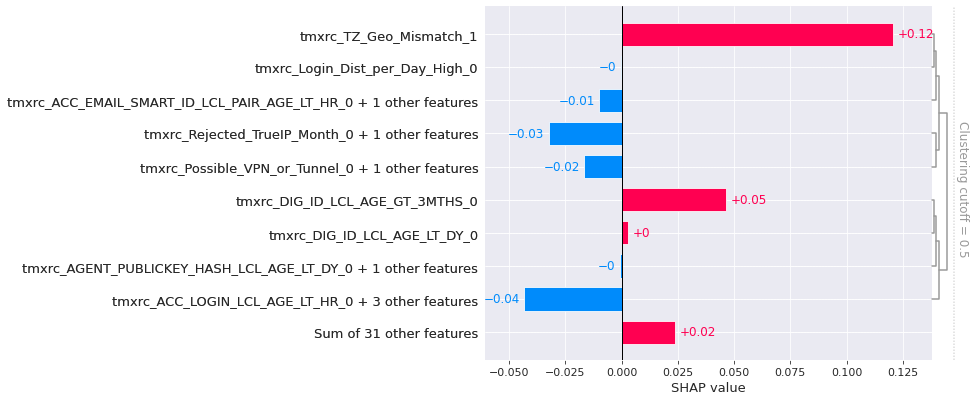

In [89]:
shap.plots.bar(shap_values[0,:,"LABEL_1"])

#### Bertviz
- virtulize pretrained MLM model

In [91]:
newmodel = BertModel.from_pretrained('./checkpoints/checkpoint-3510',output_attentions=True)

Some weights of the model checkpoint at ./checkpoints/checkpoint-3510 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./checkpoints/checkpoint-3510 and are newly initialized: ['bert.pooler.dense.bias', 'bert.poole

In [92]:
# test_sample = 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_0 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_1 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_0 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'

In [96]:
test_sample = tokenizer.decode(val_df['input_ids'][0],skip_special_tokens=True,clean_up_tokenization_spaces=True)

In [97]:
test_sample

'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day

In [98]:
inputs = tokenizer.encode_plus(test_sample, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = newmodel(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [99]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [100]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

##### Transformers-interpret

In [102]:
cls_explainer = SequenceClassificationExplainer(finetunemodel,tokenizer)

In [103]:
word_attributions = cls_explainer(test_sample_multi[0],class_name="LABEL_1")

In [104]:
word_attributions

[('[CLS]', 0.0),
 ('tmxrc_Aggregator_0', -0.02619314581178603),
 ('tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0', -0.07717449943361772),
 ('tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0', -0.012443732121858002),
 ('tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0', -0.08523568150325861),
 ('tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0', -0.25560415299473616),
 ('tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0', -0.05286784814486934),
 ('tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0', -0.030014920656878916),
 ('tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0', -0.08016526591449057),
 ('tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0', -0.043475536772796655),
 ('tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0', -0.029676969695673506),
 ('tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0', -0.003003137550944293),
 ('tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0', -0.05832282877067843),
 ('tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0', -0.010290855087469119),
 ('tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0', -0.016121956066449655),
 ('tmxrc_DIG_ID

In [105]:
cls_explainer.predicted_class_name

'LABEL_0'

In [106]:
cls_explainer.visualize("distilbert_viz.html")

In [115]:
model = XGBClassifier()
model.fit(train_data_features, train_data_labels)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:02:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=48, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
y_pred = model.predict_proba(test_data_features)

In [118]:
y_scores = y_pred[:, 1]

In [121]:
y_true = np.array(test_data_labels)

In [123]:
roc_auc_score(y_true, y_scores)

0.8840971442274685

In [360]:
X_train = input_data.train[input_data.predictors].to_numpy()

In [361]:
y_train = input_data.train['frd'].to_numpy()

In [362]:
X_val = input_data.val[input_data.predictors].to_numpy()

In [363]:
y_val = input_data.val['frd'].to_numpy()

In [364]:
X_test = input_data.test[input_data.predictors].to_numpy()

In [365]:
y_test = input_data.test['frd'].to_numpy()

#### save data locally

In [223]:
X_train.shape[0]//2

299519

In [179]:
np.save('data/X_train_small.npy', X_train[:X_train.shape[0]//2])
np.save('data/y_train_small.npy', y_train[:X_train.shape[0]//2])
np.save('data/X_val_small.npy', X_val[:X_val.shape[0]//2])
np.save('data/y_val_small.npy', y_val[:X_val.shape[0]//2])
np.save('data/X_test_small.npy', X_test[:X_test.shape[0]//2])
np.save('data/y_test_small.npy', y_test[:X_test.shape[0]//2])

In [366]:
# with open("data/X_train_small.pkl", "wb") as f:
#     pkl.dump(X_train[:270000],f)
with open("data/y_train.pkl", "wb") as f:
    pkl.dump(y_train,f)
# with open("data/X_val_small.pkl", "wb") as f:
#     pkl.dump(X_val[:X_val.shape[0]//2],f)
# with open("data/y_val_small.pkl", "wb") as f:
#     pkl.dump(y_val[:X_val.shape[0]//2],f)
# with open("data/X_test_small.pkl", "wb") as f:
#     pkl.dump(X_test[:X_test.shape[0]//2],f)
# with open("data/y_test_small.pkl", "wb") as f:
#     pkl.dump(y_test[:X_test.shape[0]//2],f)

In [220]:
y_train = np.load('data/y_train_small.pkl',allow_pickle=True) # load

In [221]:
y_train.shape

(299519,)

In [190]:
X_train[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1])

In [303]:
X_train_tensor = numpy_to_tensor(
        X_train, torch.long)
y_train_tensor = numpy_to_tensor(
        y_train, torch.long)
X_val_tensor = numpy_to_tensor(
        X_val, torch.long)
y_val_tensor = numpy_to_tensor(
        y_val, torch.long)
X_test_tensor = numpy_to_tensor(
        X_test, torch.long)
y_test_tensor = numpy_to_tensor(
        y_test, torch.long)

In [304]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
valid_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [305]:
BATCH_SIZE=512

In [306]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      drop_last=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE,
                      shuffle=False, drop_last=True, num_workers=0)

### Create Model

- Use the Multi-Head Attention Architecture
- Modified to support tabular data
- Reference paper:


In [307]:
cat_feature_dims = [2]*45

In [308]:
cons_feature_dims = 0

In [311]:
model = TabTransformer(cat_feature_dims, embed_dim=32, depth=4, n_heads=4, att_dropout=0.1, an_dropout=0.1, ffn_dropout=0.1, mlp_dims=[16, 8]).to(device)

In [312]:
model

TabTransformer(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(90, 32)
  )
  (transformer): TabTransformerEncoder(
    (transformer): Sequential(
      (0): TabTransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (q_w): Linear(in_features=32, out_features=32, bias=False)
          (k_w): Linear(in_features=32, out_features=32, bias=False)
          (v_w): Linear(in_features=32, out_features=32, bias=False)
          (fc): Linear(in_features=32, out_features=32, bias=False)
          (attention): ScaleDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (ffn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=64, out_features=32, bias=True)
          )
        )
        (add_norm1): AddNormConnection(
          (layer_norm): LayerNorm

In [214]:
LR = 0.005

In [215]:
loss = torch.nn.BCEWithLogitsLoss()

In [216]:
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))

In [313]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [314]:
params

68241

In [ ]:
LEARNING_RATE = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

####  new transformer

In [271]:
model = TabTransformer(
    categories=cat_feature_dims,
    dim=16,
    dim_out=1,
    depth=2,
    heads=4,
    attn_dropout=0.1,
    ff_dropout=0.1,
    mlp_hidden_mults=(8, 4),
    mlp_act=nn.ReLU(),
)
model.to(device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters = ", params)

Total trainable parameters =  795297


#### Create folder to save trained model

In [265]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10
early_stopping = EarlyStopping(output_path='checkpoints/Attention_Test.pt',
                               patience=patience,
                               verbose=True)

In [ ]:
for epoch in range(20):
    train_loss = train_tool(model, optimizer, train_dl, loss, device=device)
    valid_loss = test_tool(model, valid_dl, loss, device=device)
    print(f'\n Epoch {epoch + 1}  '
          f'train loss:{round(train_loss, 4)}. '
          f'test loss:{round(valid_loss, 4)}')
     
    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

100%|██████████| 1169/1169 [03:02<00:00,  6.39it/s]



 Epoch 1  train loss:0.6947. test loss:0.6947
EarlyStopping counter: 1 out of 10


 19%|█▉        | 226/1169 [00:34<02:23,  6.57it/s]

#### Load Trained Model for Testing

In [315]:
####### load and evaluate ####################

model.load_state_dict(torch.load('checkpoints/Attention_Test.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [316]:
model

TabTransformer(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(90, 32)
  )
  (transformer): TabTransformerEncoder(
    (transformer): Sequential(
      (0): TabTransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (q_w): Linear(in_features=32, out_features=32, bias=False)
          (k_w): Linear(in_features=32, out_features=32, bias=False)
          (v_w): Linear(in_features=32, out_features=32, bias=False)
          (fc): Linear(in_features=32, out_features=32, bias=False)
          (attention): ScaleDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (ffn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=64, out_features=32, bias=True)
          )
        )
        (add_norm1): AddNormConnection(
          (layer_norm): LayerNorm

In [317]:
test_dl = DataLoader(test_ds, batch_size=10,
                      shuffle=False, drop_last=False, num_workers=0)

In [318]:
pred,pred_tensor = predict_prob(model, test_dl, device=device)

In [243]:
# eval with loaded model

print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred)}")

AUC of loaded model's prediction is: 0.8815226590593762


#### classification report

In [319]:
pred

[0.19888725876808167,
 0.049344826489686966,
 0.03029531240463257,
 0.020063338801264763,
 0.013867815025150776,
 0.01674327440559864,
 0.012327075004577637,
 0.02367938868701458,
 0.029109807685017586,
 0.03076174296438694,
 0.1516122668981552,
 0.19775287806987762,
 0.05934857577085495,
 0.1516122668981552,
 0.01783246174454689,
 0.1516122668981552,
 0.049344826489686966,
 0.01245826855301857,
 0.014775492250919342,
 0.00861857458949089,
 0.05002698302268982,
 0.049344826489686966,
 0.1516122668981552,
 0.18419566750526428,
 0.014775492250919342,
 0.24403728544712067,
 0.1516122668981552,
 0.03139030188322067,
 0.21523229777812958,
 0.011688580736517906,
 0.8158630728721619,
 0.049344826489686966,
 0.9858248233795166,
 0.13095901906490326,
 0.2222657948732376,
 0.015454059466719627,
 0.18811331689357758,
 0.011031103320419788,
 0.049344826489686966,
 0.02208341658115387,
 0.011688580736517906,
 0.8831533193588257,
 0.049344826489686966,
 0.014775492250919342,
 0.03029531240463257,
 0

In [320]:
pred_labels_prob = []
for i in pred_tensor:
    pred_label = torch.round(i).cpu().numpy()
    pred_labels_prob.append(pred_label)

In [321]:
pred_labels = [round(a.squeeze().tolist()) for a in pred_labels_prob]

In [322]:
# eval with loaded model

print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred_labels)}")

AUC of loaded model's prediction is: 0.6925878840044087


In [323]:
unique_elements, counts_elements = np.unique(pred_labels, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1]
 [175291  10150]]


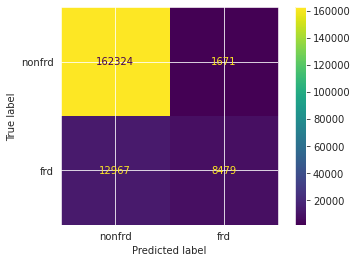

In [324]:
cm = confusion_matrix(y_test, pred_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['nonfrd','frd'])
cmd.plot()

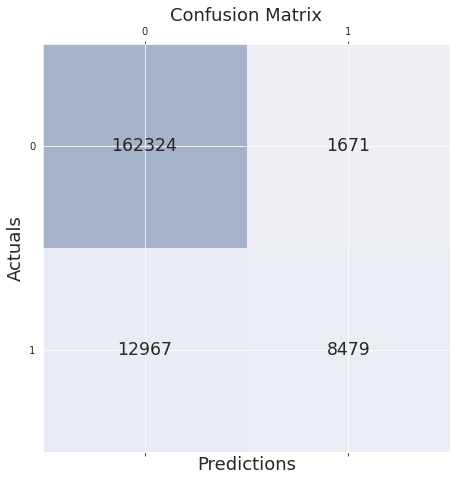

In [325]:
conf_matrix = confusion_matrix(y_test, pred_labels)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Best Threshold=0.147250, G-Mean=0.807


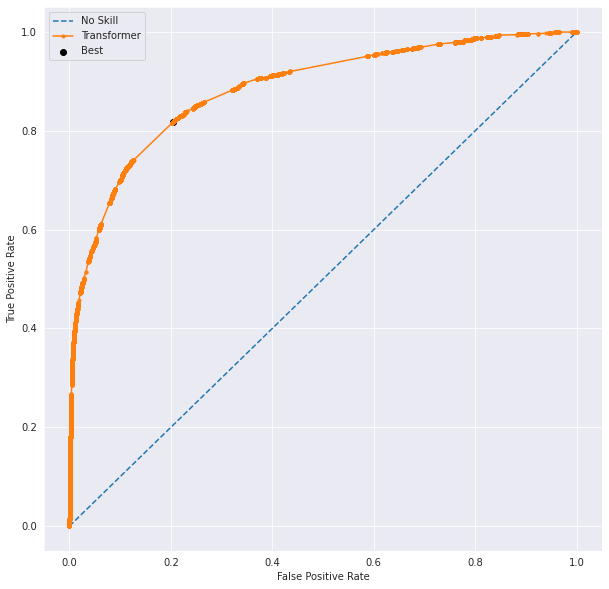

In [326]:
fpr, tpr, thresholds = roc_curve(y_test, pred,pos_label=1)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
best_threshold = thresholds[ix]
# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Transformer')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [327]:
pred_labels_new_threthold = []
for i in pred:
    pred_label = 1 if i > best_threshold else 0
    pred_labels_new_threthold.append(pred_label)

#### when threshlod = 0.5

In [328]:
print(classification_report(y_test, pred_labels,target_names=['nonfrd','frd']))

              precision    recall  f1-score   support

      nonfrd       0.93      0.99      0.96    163995
         frd       0.84      0.40      0.54     21446

    accuracy                           0.92    185441
   macro avg       0.88      0.69      0.75    185441
weighted avg       0.92      0.92      0.91    185441



In [329]:
print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred_labels)}")

AUC of loaded model's prediction is: 0.6925878840044087


#### with best threshold

In [330]:
print(classification_report(y_test, pred_labels_new_threthold,target_names=['nonfrd','frd']))

              precision    recall  f1-score   support

      nonfrd       0.97      0.80      0.87    163995
         frd       0.34      0.82      0.48     21446

    accuracy                           0.80    185441
   macro avg       0.66      0.81      0.68    185441
weighted avg       0.90      0.80      0.83    185441



In [331]:
print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred_labels_new_threthold)}")

AUC of loaded model's prediction is: 0.8069234207921006


#### precision_recall_curve

Best Threshold=0.280868, F-Score=0.590


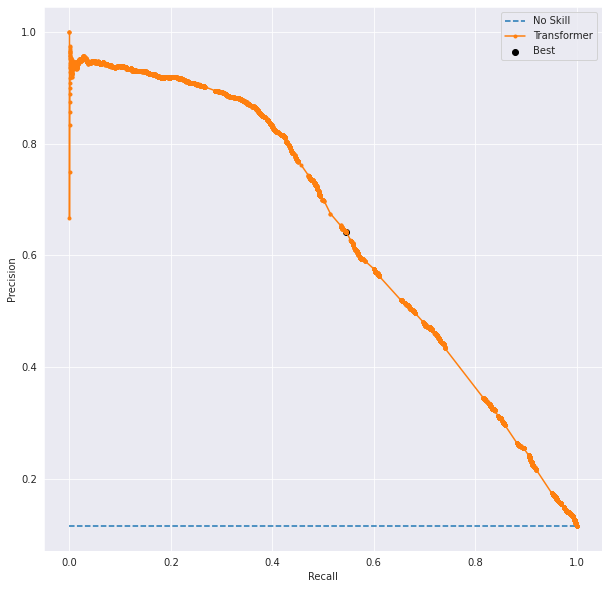

In [332]:
precision, recall, thresholds = precision_recall_curve(y_test, pred,pos_label=1)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_threshold = thresholds[ix]
# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(10, 10))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Transformer')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

#### with best threshold from precision-recall curve

In [333]:
pred_labels_new_threthold = []
for i in pred:
    pred_label = 1 if i > best_threshold else 0
    pred_labels_new_threthold.append(pred_label)

In [334]:
print(classification_report(y_test, pred_labels_new_threthold,target_names=['nonfrd','frd']))

              precision    recall  f1-score   support

      nonfrd       0.94      0.96      0.95    163995
         frd       0.64      0.55      0.59     21446

    accuracy                           0.91    185441
   macro avg       0.79      0.75      0.77    185441
weighted avg       0.91      0.91      0.91    185441



In [335]:
print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred_labels_new_threthold)}")

AUC of loaded model's prediction is: 0.7528611078467627


In [34]:
#### SHAP Deep Explainer

##### KernelExplainer

In [127]:
train_dl_shap = DataLoader(train_ds, batch_size=1000,shuffle=False,
                      drop_last=False, num_workers=0)
test_dl_shap = DataLoader(test_ds, batch_size=20,
                      shuffle=False, drop_last=False, num_workers=0)

In [128]:
def pred(data):
    tensor_input = numpy_to_tensor(
        data, torch.long)
    pred_proba = predict_prob_noy(model, tensor_input, device=device)
    
    return np.vstack(pred_proba)

In [129]:
def shap_data(train_dl,test_dl,modified_rcs):
    X_train,y_train = next(iter(train_dl))
    X_test,y_test = next(iter(test_dl))
    cols = modified_rcs
    X_train = pd.DataFrame(X_train.numpy(),columns=cols)
    X_test = pd.DataFrame(X_test.numpy(), columns=cols)
    return X_train, X_test

In [130]:
X_train, X_test = shap_data(train_dl_shap,test_dl_shap,modified_rcs)

In [131]:
print(X_train.shape)
print(X_test.shape)

(1000, 45)
(20, 45)


In [132]:
e = shap.KernelExplainer(pred, X_train)

100%|██████████| 1000/1000 [00:04<00:00, 231.08it/s]
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [96]:
shap_values = e.shap_values(X_test, nsamples=1, l1_reg=False)

  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 321.33it/s]

100%|██████████| 1000/1000 [00:03<00:00, 252.28it/s][A

100%|██████████| 1/1 [00:00<00:00, 313.52it/s]

100%|██████████| 1000/1000 [00:03<00:00, 253.54it/s][A

100%|██████████| 1/1 [00:00<00:00, 34.78it/s]

100%|██████████| 1000/1000 [00:04<00:00, 215.78it/s][A

100%|██████████| 1/1 [00:00<00:00, 305.97it/s]

100%|██████████| 1000/1000 [00:04<00:00, 231.40it/s][A

100%|██████████| 1/1 [00:00<00:00, 259.32it/s]

100%|██████████| 1000/1000 [00:04<00:00, 219.62it/s][A

100%|██████████| 1/1 [00:00<00:00, 266.07it/s]

100%|██████████| 1000/1000 [00:04<00:00, 222.19it/s][A

100%|██████████| 1/1 [00:00<00:00, 127.15it/s]

100%|██████████| 1000/1000 [00:04<00:00, 241.24it/s]

100%|██████████| 1/1 [00:00<00:00, 319.83it/s]

100%|██████████| 1000/1000 [00:04<00:00, 238.13it/s][A

100%|██████████| 1/1 [00:00<00:00, 322.42it/s]

100%|██████████| 1000/1000 [00:04<00:00, 235.93it/s][A

100%|██████████| 1/1 [00:00<00:00, 265.83it/s]

100%|██████████| 1

##### Explain a single prediction from the testset

In [92]:
shap_values = e.shap_values(X_test.iloc[4,:], nsamples=1, l1_reg=False)

100%|██████████| 1000/1000 [00:04<00:00, 237.40it/s]


In [93]:
shap.force_plot(e.expected_value[0], shap_values[0], X_test.iloc[4,:])

##### Explain all the predictions in the test dataset

In [104]:
shap.force_plot(e.expected_value[0], shap_values[0], X_test)

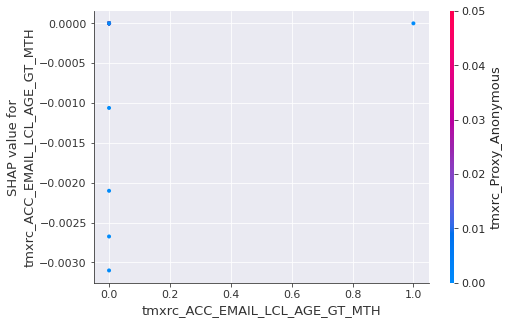

In [138]:
shap.dependence_plot(6, shap_values[0], X_test, interaction_index="tmxrc_Proxy_Anonymous")

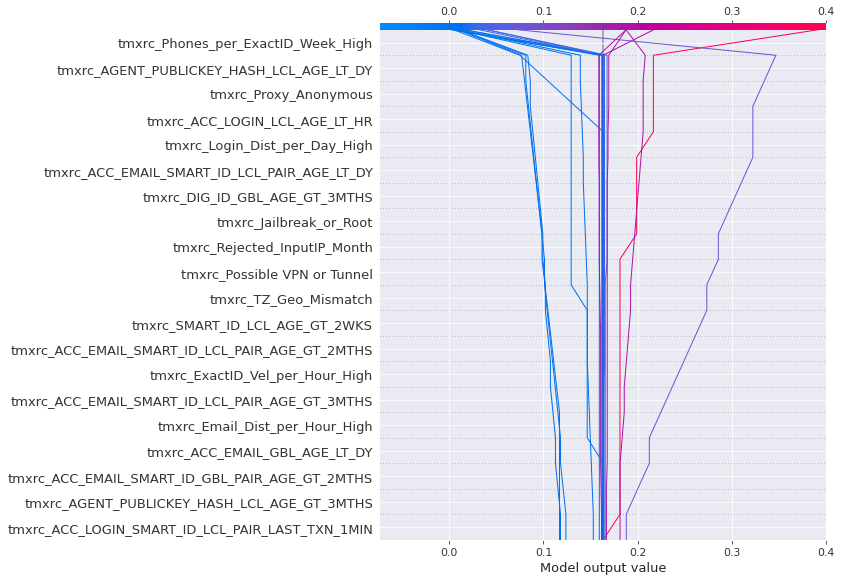

In [147]:
shap.decision_plot(e.expected_value[0], shap_values[0], modified_rcs)

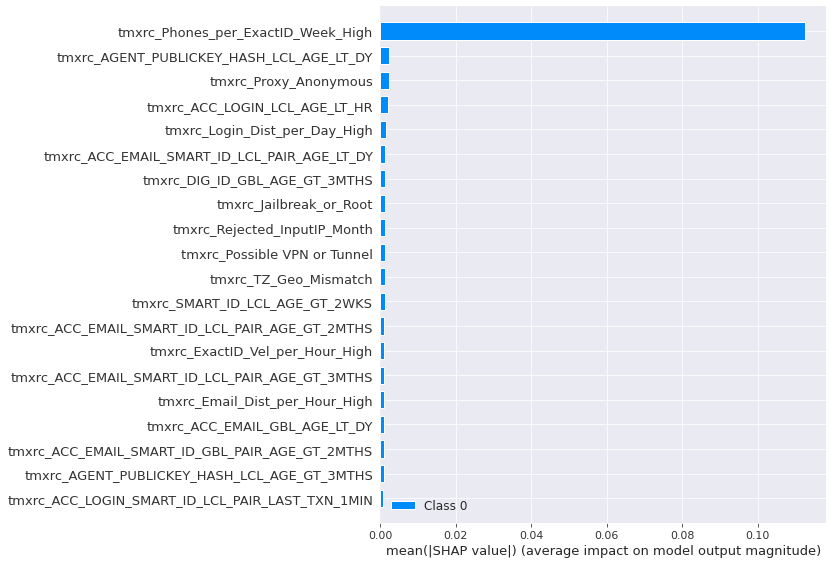

In [98]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## 3. Adversarial Autoencoder Neural Network

The Adversarial Autoencoder Neural Network (AAE) architecture, as illustrated in the figure below, extends the concept
of Autoencoder Neural Networks (AE) by imposing an arbitrary prior on the AEs latent space using a GAN training setup. This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder
network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\theta}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) ≈ q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

### 3.1 AAE Implementation - Encoder / Generator Network $q_{\theta}(z|x)$

Now, let's start implementing an AAE by first implementing the encoder-generator network $q_{\theta}(z|x)$ using PyTorch. For the encoder-generator, we aim to implement a network consisting of **five fully-connected layers**. Furthermore, the encoder-generator is specified by the following number of neurons per layer: "618-256-64-16-4-2". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 64, 16, 4 and 2 neurons respectively.

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9].
>- `nn.init.constant`: inits the layer bias with a constant value of 0.0. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active.

In [ ]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_R5(self.map_L5(x))

        # return result
        return x

In [ ]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])


if (torch.backends.cudnn.version() != None):
    encoder_train = encoder_train.cuda()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [ ]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

### 3.2 AAE Implementation - Decoder Network $p_{\theta}(x|z)$

Let's continue the AAE by implementing the corresponding decoder network. The decoder also consists of five fully-connected layers. Furthermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer wise inversion "2-4-16-64-256" of the encoder network layers.

In [ ]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

### Prepare data for Pytorch